# Example 1: Cepstral Analysis of solid amorphous Silica

This example shows the basic usage of *sportran* to compute the thermal conductivity of a classical MD simulation of a-SiO$_2$.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
try:
    import sportran as st
except ImportError:
    from sys import path
    path.append('..')
    import sportran as st

c = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
%matplotlib notebook

## 1. Load trajectory

Read the heat current from a simple column-formatted file. The desired columns are selected based on their header (e.g. with LAMMPS format).

For other input formats see corresponding the example.

In [3]:
jfile = st.i_o.TableFile('./data/Silica.dat', group_vectors=True)

# Solid Silica - BKS potential, melted and quenched
# 216 atoms, T~1000K, dens~2.295g/cm^3
# NVE, dt = 1.0 fs, 50 ns, output_step = 1.0 fs
# Temperature = 1065.705630 K, Volume = 3130.431110818 A^3
# LAMMPS metal units
c_flux1[1] c_flux1[2] c_flux1[3]
 #####################################
  all_ckeys =  [('flux1', array([0, 1, 2]))]
 #####################################
Data length =  100001


In [4]:
jfile.read_datalines(start_step=0, NSTEPS=0, select_ckeys=['flux1'])

  ckey =  [('flux1', array([0, 1, 2]))]
    step =    100000 - 100.00% completed
  ( 100000 ) steps read.
DONE.  Elapsed time:  0.5751736164093018 seconds


{'flux1': array([[  91.472925,  630.61992 ,  199.16002 ],
        [  71.403952,  666.80601 ,  274.30247 ],
        [  47.754737,  678.10914 ,  305.95706 ],
        ...,
        [ 466.489   , -360.14259 ,  -47.286976],
        [ 414.3014  , -378.42595 ,  166.42152 ],
        [ 331.99113 , -400.35311 ,  378.13009 ]])}

## 2. Heat Current

Define a **HeatCurrent** from the trajectory, with the correct parameters.

In [5]:
DT_FS = 1.0                 # time step [fs]
TEMPERATURE = 1065.705630   # temperature [K]
VOLUME = 3130.431110818     # volume [A^3]

j = st.HeatCurrent(jfile.data['flux1'], UNITS= 'metal', DT_FS=DT_FS,
                   TEMPERATURE=TEMPERATURE, VOLUME=VOLUME)

Using single component code.


<IPython.core.display.Javascript object>


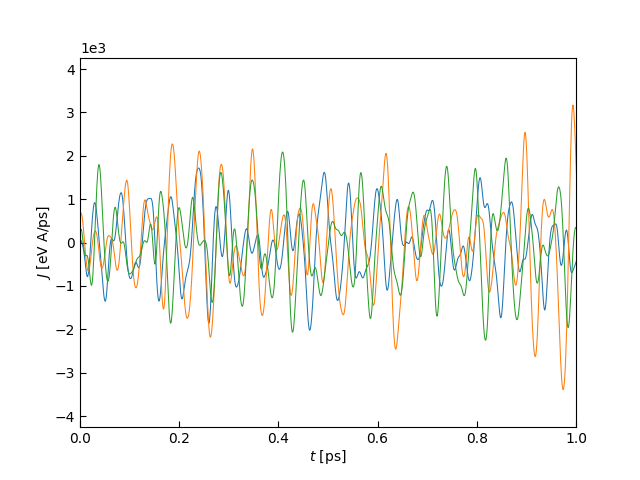

In [6]:
# trajectory
f = plt.figure()
ax = plt.plot(j.timeseries()/1000., j.traj);
plt.xlim([0, 1.0])
plt.xlabel(r'$t$ [ps]')
plt.ylabel(r'$J$ [eV A/ps]');

Compute the **Power Spectral Density** ($\rm PSD$) and filter it for visualization.

<IPython.core.display.Javascript object>


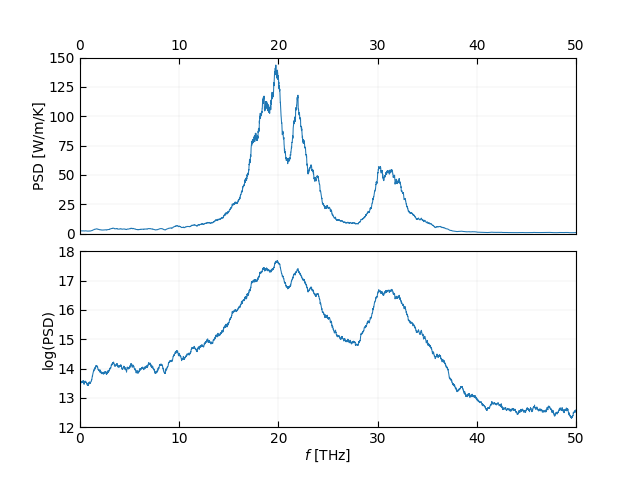

500.0


In [7]:
# Periodogram with given filtering window width
ax = j.plot_periodogram(PSD_FILTER_W=0.5, kappa_units=True)
print(j.Nyquist_f_THz)
plt.xlim([0, 50])
ax[0].set_ylim([0, 150]);
ax[1].set_ylim([12, 18]);

## 3. Resampling

If the Nyquist frequency is very high (*i.e.* the sampling time is very small), such that the log-spectrum goes to low values, you may want *resample* your time series, in order to reduce the maximum frequency to $f^*$.
Before performing that operation, the time series is automatically filtered to reduce the amount of aliasing introduced. Ideally you do not want to go too low in $f^*$, because the statistical error may increase. In an intermediate region the results should not change. 

To perform resampling you can choose the resampling frequency $f^*$ (`fstar_THz`) or the resampling step (`TSKIP`). If you choose $f^*$, the code will try to find the closest value allowed.
The resulting $\rm PSD$ can be visualized to ensure that the low-frequency region was not affected by this operations

Using single component code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     500.00000 THz
 Resampling freq          f* =      27.77778 THz
 Sampling time         TSKIP =            18 steps
                             =        18.000 fs
 Original  n. of frequencies =         50001
 Resampled n. of frequencies =          2778
 PSD      @cutoff  (pre-filter&sample) ~ 3173093.88767
                  (post-filter&sample) ~ 2635454.95726
 log(PSD) @cutoff  (pre-filter&sample) ~     14.79703
                  (post-filter&sample) ~     14.62837
 min(PSD)          (pre-filter&sample) =      0.97609
 min(PSD)         (post-filter&sample) =  62691.79433
 % of original PSD Power f<f* (pre-filter&sample)  = 77.029 %
-----------------------------------------------------



<IPython.core.display.Javascript object>


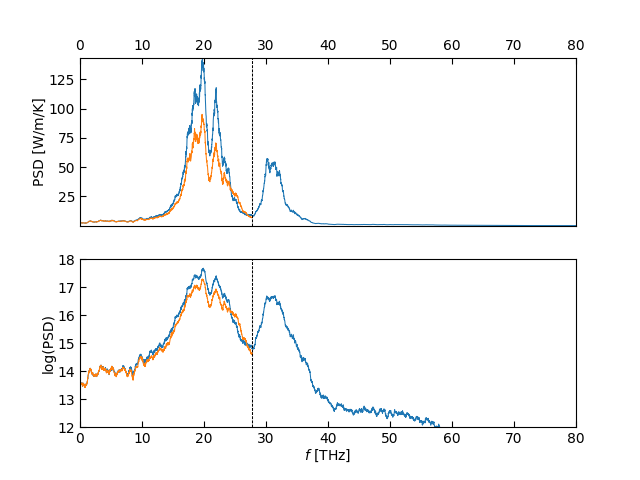

In [8]:
FSTAR_THZ = 28.0
jf, ax = j.resample(fstar_THz=FSTAR_THZ, plot=True, freq_units='thz')
plt.xlim([0, 80])
ax[1].set_ylim([12,18]);

<IPython.core.display.Javascript object>


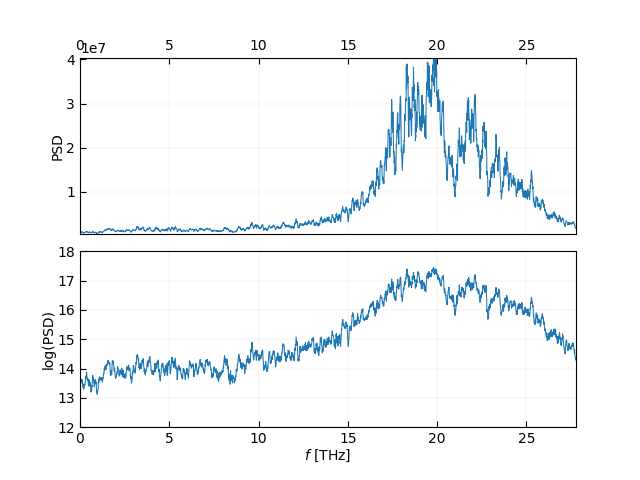

In [9]:
ax = jf.plot_periodogram(PSD_FILTER_W=0.1)
ax[1].set_ylim([12, 18]);

## 4. Cepstral Analysis

Perform Cepstral Analysis. The code will perform the following operations:
 1. compute the parameters describing the theoretical distribution of the $\rm PSD$
 2. compute the Cepstral coefficients by Fourier transforming the $\log(\rm{PSD})$
 3. apply the Akaike Information Criterion, to choose the number of cepstral coefficients $P^*$
 4. return the resulting transport coefficient (thermal conductivity) $\kappa$

In [10]:
jf.cepstral_analysis()

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 37  (P* = 38, corr_factor = 1.000000)
  L_0*   =          13.395456 +/-   0.103277
  S_0*   =      950203.538450 +/- 98134.481881
-----------------------------------------------------
  kappa* =           2.484534 +/-   0.256596  W/m/K
-----------------------------------------------------



c_k =  [ 1.52991432e+01 -6.79075038e-01 -1.52991190e-01 ... -7.74510541e-03
  7.38870817e-03  8.29678141e-03]


<IPython.core.display.Javascript object>


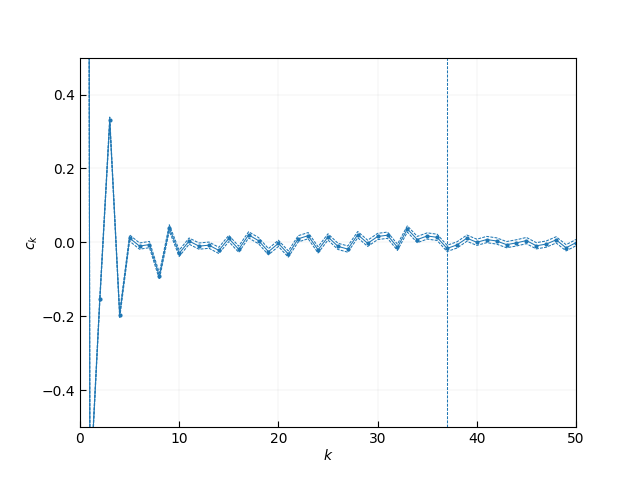

In [11]:
# Cepstral Coefficients
print('c_k = ', jf.dct.logpsdK)

ax = jf.plot_ck()
ax.set_xlim([0, 50])
ax.set_ylim([-0.5, 0.5])
ax.grid();

<IPython.core.display.Javascript object>


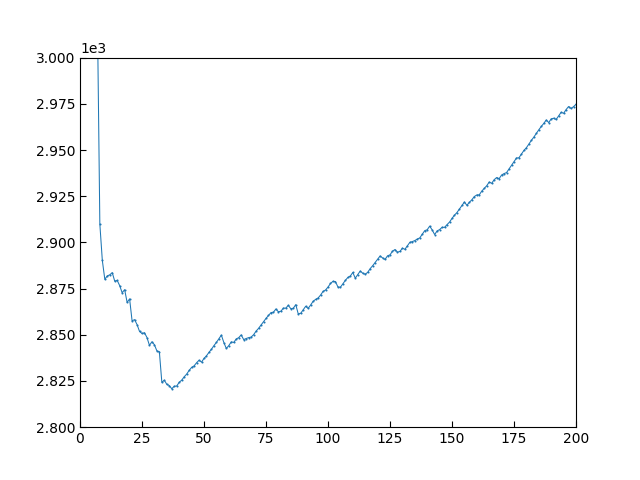

K of AIC_min = 37
AIC_min = 2820.804281


In [12]:
# AIC function
f = plt.figure()
plt.plot(jf.dct.aic, '.-', c=c[0])
plt.xlim([0, 200])
plt.ylim([2800, 3000]);

print('K of AIC_min = {:d}'.format(jf.dct.aic_Kmin))
print('AIC_min = {:f}'.format(jf.dct.aic_min))

Plot the thermal conductivity $\kappa$ as a function of the cutoff $P^*$

<IPython.core.display.Javascript object>


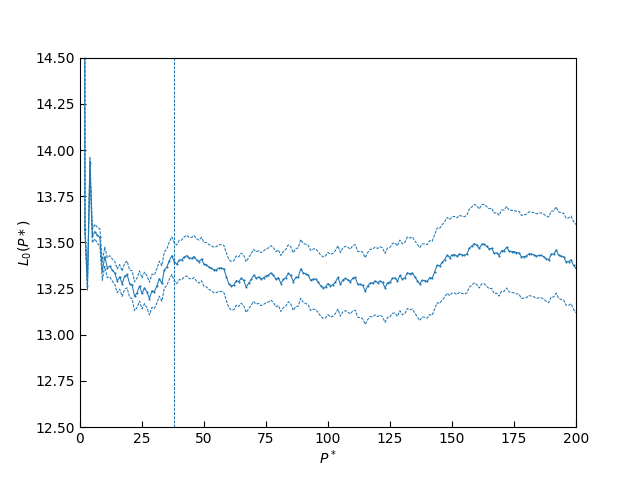

K of AIC_min = 37
AIC_min = 2820.804281


In [13]:
# L_0 as a function of cutoff K
ax = jf.plot_L0_Pstar()
ax.set_xlim([0, 200])
ax.set_ylim([12.5, 14.5]);

print('K of AIC_min = {:d}'.format(jf.dct.aic_Kmin))
print('AIC_min = {:f}'.format(jf.dct.aic_min))

<IPython.core.display.Javascript object>


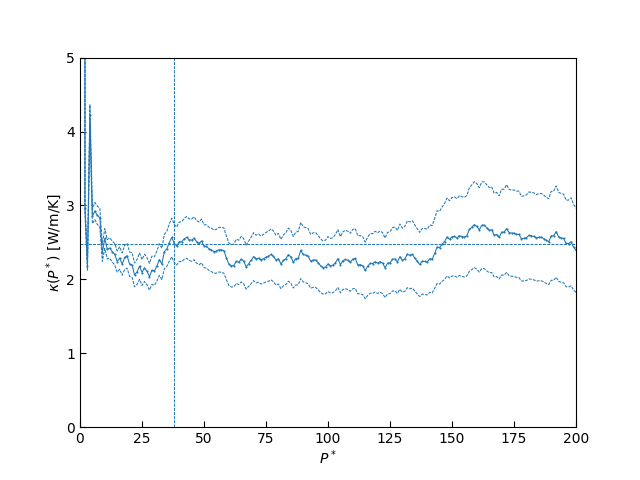

K of AIC_min = 37
AIC_min = 2820.804281


In [14]:
# kappa as a function of cutoff K
ax = jf.plot_kappa_Pstar()
ax.set_xlim([0,200])
ax.set_ylim([0, 5.0]);

print('K of AIC_min = {:d}'.format(jf.dct.aic_Kmin))
print('AIC_min = {:f}'.format(jf.dct.aic_min))

Print the results :)

In [15]:
results = jf.cepstral_log
print(results)

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 37  (P* = 38, corr_factor = 1.000000)
  L_0*   =          13.395456 +/-   0.103277
  S_0*   =      950203.538450 +/- 98134.481881
-----------------------------------------------------
  kappa* =           2.484534 +/-   0.256596  W/m/K
-----------------------------------------------------



You can now visualize the filtered PSD...

<IPython.core.display.Javascript object>


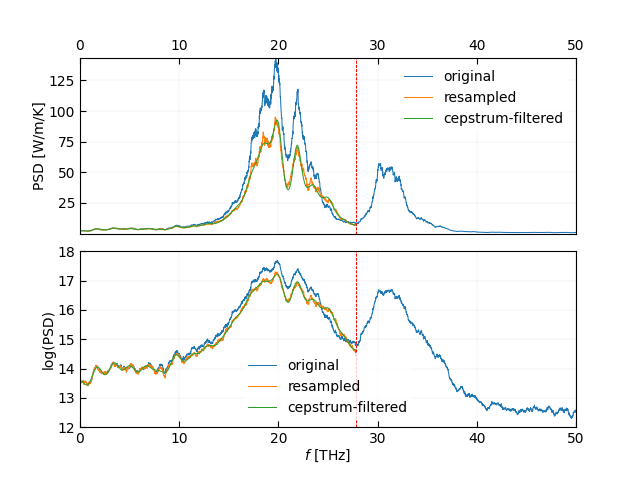

In [16]:
# filtered log-PSD
ax = j.plot_periodogram(0.5, kappa_units=True)
ax = jf.plot_periodogram(0.5, axes=ax, kappa_units=True)
ax = jf.plot_cepstral_spectrum(axes=ax, kappa_units=True)
ax[0].axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
ax[1].axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
plt.xlim([0., 50.])
ax[1].set_ylim([12,18])
ax[0].legend(['original', 'resampled', 'cepstrum-filtered'])
ax[1].legend(['original', 'resampled', 'cepstrum-filtered']);